# Fully-Connected Neural Nets
##In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

##In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

##The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

##After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

##In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.

In [2]:
# As usual, a bit of setup
import time
import numpy as np
import  matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000L, 3L, 32L, 32L)
X_train:  (49000L, 3L, 32L, 32L)
X_test:  (1000L, 3L, 32L, 32L)
y_val:  (1000L,)
y_train:  (49000L,)
y_test:  (1000L,)


# Affine layer: foward
##Open the file `cs231n/layers.py` and implement the `affine_forward` function.

##Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print 'Testing affine_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing affine_forward function:
difference:  9.76984772881e-10


# Affine layer: backward
##Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print 'Testing affine_backward function:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_backward function:
dx error:  1.81921201544e-10
dw error:  6.56868254571e-11
db error:  2.7790542505e-10


# ReLU layer: forward
##Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print 'Testing relu_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward
##Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print 'Testing relu_backward function:'
print 'dx error: ', rel_error(dx_num, dx)

Testing relu_backward function:
dx error:  3.27561113355e-12


# "Sandwich" layers
##There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

##For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print 'Testing affine_relu_forward:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_relu_forward:
dx error:  2.64493946725e-10
dw error:  5.895569255e-10
db error:  1.892888933e-11


# Loss layers: Softmax and SVM
##You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

##You can make sure that the implementations are correct by running the following:

In [8]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print 'Testing svm_loss:'
print 'loss: ', loss
print 'dx error: ', rel_error(dx_num, dx)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print '\nTesting softmax_loss:'
print 'loss: ', loss
print 'dx error: ', rel_error(dx_num, dx)

Testing svm_loss:
loss:  9.00077523257
dx error:  3.0387355051e-09

Testing softmax_loss:
loss:  2.30266305177
dx error:  8.44866456445e-09


# Two-layer network
##In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

##Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print 'Testing initialization ... '
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print 'Testing test-time forward pass ... '
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print 'Testing training loss (no regularization)'
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print 'Running numeric gradient check with reg = ', reg
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0


W1 relative error: 1.22e-08


W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7


W1 relative error: 8.18e-07


W2 relative error: 7.98e-08
b1 relative error: 1.09e-09
b2 relative error: 9.09e-10


# Solver
##In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

##Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
data1 = {
    'X_train': data['X_train'],# training data
    'y_train': data['y_train'],# training labels
    'X_val': data['X_val'],# validation data
    'y_val': data['y_val'] # validation labels
  }
solver = Solver(model, data1,
              update_rule='sgd',
              optim_config={
                'learning_rate': 1e-3,
              },
              lr_decay=0.95,
              num_epochs=10, batch_size=100,
              print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.300710


(Epoch 0 / 10) train acc: 0.138000; val_acc: 0.148000


(Iteration 101 / 4900) loss: 1.831352


(Iteration 201 / 4900) loss: 1.796134


(Iteration 301 / 4900) loss: 1.519896


(Iteration 401 / 4900) loss: 1.571618


(Epoch 1 / 10) train acc: 0.428000; val_acc: 0.427000
(Iteration 501 / 4900) loss: 1.494955


(Iteration 601 / 4900) loss: 1.527328


(Iteration 701 / 4900) loss: 1.469680


(Iteration 801 / 4900) loss: 1.439874


(Iteration 901 / 4900) loss: 1.365245


(Epoch 2 / 10) train acc: 0.507000; val_acc: 0.479000


(Iteration 1001 / 4900) loss: 1.694142


(Iteration 1101 / 4900) loss: 1.261479


(Iteration 1201 / 4900) loss: 1.524728


(Iteration 1301 / 4900) loss: 1.342343


(Iteration 1401 / 4900) loss: 1.455434


(Epoch 3 / 10) train acc: 0.494000; val_acc: 0.463000


(Iteration 1501 / 4900) loss: 1.414522


(Iteration 1601 / 4900) loss: 1.309364


(Iteration 1701 / 4900) loss: 1.335014


(Iteration 1801 / 4900) loss: 1.490704


(Iteration 1901 / 4900) loss: 1.447526


(Epoch 4 / 10) train acc: 0.509000; val_acc: 0.505000


(Iteration 2001 / 4900) loss: 1.445823


(Iteration 2101 / 4900) loss: 1.188784


(Iteration 2201 / 4900) loss: 1.153544


(Iteration 2301 / 4900) loss: 1.201618


(Iteration 2401 / 4900) loss: 1.232372


(Epoch 5 / 10) train acc: 0.550000; val_acc: 0.504000


(Iteration 2501 / 4900) loss: 1.255945


(Iteration 2601 / 4900) loss: 1.123504


(Iteration 2701 / 4900) loss: 1.320322


(Iteration 2801 / 4900) loss: 1.209890


(Iteration 2901 / 4900) loss: 1.318278


(Epoch 6 / 10) train acc: 0.540000; val_acc: 0.482000


(Iteration 3001 / 4900) loss: 1.015782


(Iteration 3101 / 4900) loss: 1.146163


(Iteration 3201 / 4900) loss: 1.101594


(Iteration 3301 / 4900) loss: 1.262782


(Iteration 3401 / 4900) loss: 1.069385


(Epoch 7 / 10) train acc: 0.555000; val_acc: 0.515000


(Iteration 3501 / 4900) loss: 1.052917


(Iteration 3601 / 4900) loss: 1.048144


(Iteration 3701 / 4900) loss: 1.040725


(Iteration 3801 / 4900) loss: 1.181619


(Iteration 3901 / 4900) loss: 1.229446


(Epoch 8 / 10) train acc: 0.604000; val_acc: 0.512000


(Iteration 4001 / 4900) loss: 1.058444


(Iteration 4101 / 4900) loss: 1.285998


(Iteration 4201 / 4900) loss: 1.051523


(Iteration 4301 / 4900) loss: 1.236644


(Iteration 4401 / 4900) loss: 1.194376
(Epoch 9 / 10) train acc: 0.578000; val_acc: 0.501000


(Iteration 4501 / 4900) loss: 1.102237


(Iteration 4601 / 4900) loss: 1.124794


(Iteration 4701 / 4900) loss: 1.183468


(Iteration 4801 / 4900) loss: 1.194689


(Epoch 10 / 10) train acc: 0.623000; val_acc: 0.495000


In [11]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(14, 12)
plt.show(block=True)
plt.show()

# Multilayer network
##Next you will implement a fully-connected network with an arbitrary number of hidden layers.

##Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

##Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

##As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

##For gradient checking, you should expect to see errors around 1e-6 or less.

In [12]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print 'Running check with reg = ', reg
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Running check with reg =  0
Initial loss:  2.30153959356
W1 relative error: 2.45e-07


W2 relative error: 5.59e-07
W3 relative error: 1.11e-07
b1 relative error: 2.63e-08
b2 relative error: 2.44e-09


b3 relative error: 1.99e-10
Running check with reg =  3.14
Initial loss:  7.46196871604
W1 relative error: 1.40e-07


W2 relative error: 5.42e-08
W3 relative error: 1.92e-08
b1 relative error: 1.98e-08
b2 relative error: 2.02e-08
b3 relative error: 3.63e-10


##As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 185.875378
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.122000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.097000
(Epoch 2 / 20) train acc: 0.660000; val_acc: 0.135000
(Epoch 3 / 20) train acc: 0.760000; val_acc: 0.119000
(Epoch 4 / 20) train acc: 0.840000; val_acc: 0.114000


cs231n\layers.py:560: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch 5 / 20) train acc: 0.840000; val_acc: 0.138000
(Iteration 11 / 40) loss: 12.251637
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.130000
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.135000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.130000


(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.130000
(Iteration 21 / 40) loss: 0.000025
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.130000


(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.130000
(Iteration 31 / 40) loss: 0.000001
(Epoch 16 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 18 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 19 / 20) train acc: 1.000000; val_acc: 0.130000


(Epoch 20 / 20) train acc: 1.000000; val_acc: 0.130000


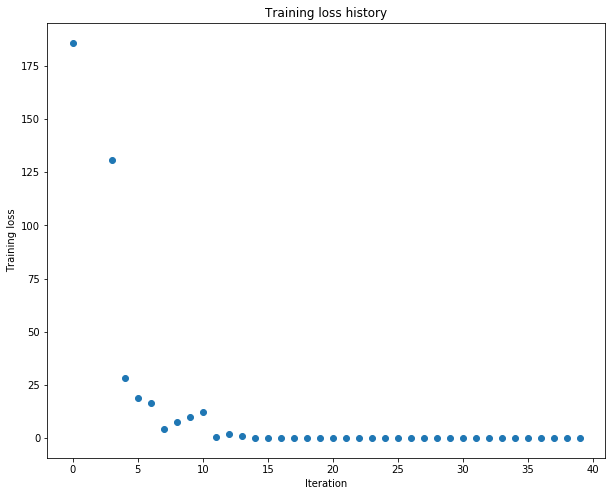

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3
weight_scale = 1e-1
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

##Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 25.114385
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.084000
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.102000
(Epoch 2 / 20) train acc: 0.480000; val_acc: 0.114000
(Epoch 3 / 20) train acc: 0.520000; val_acc: 0.110000


(Epoch 4 / 20) train acc: 0.740000; val_acc: 0.120000
(Epoch 5 / 20) train acc: 0.900000; val_acc: 0.113000
(Iteration 11 / 40) loss: 0.355512
(Epoch 6 / 20) train acc: 0.920000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.114000


(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.115000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.111000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.117000
(Iteration 21 / 40) loss: 0.029260
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.115000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.112000


(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.113000
(Iteration 31 / 40) loss: 0.022105
(Epoch 16 / 20) train acc: 1.000000; val_acc: 0.115000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.114000


(Epoch 18 / 20) train acc: 1.000000; val_acc: 0.113000
(Epoch 19 / 20) train acc: 1.000000; val_acc: 0.114000
(Epoch 20 / 20) train acc: 1.000000; val_acc: 0.114000


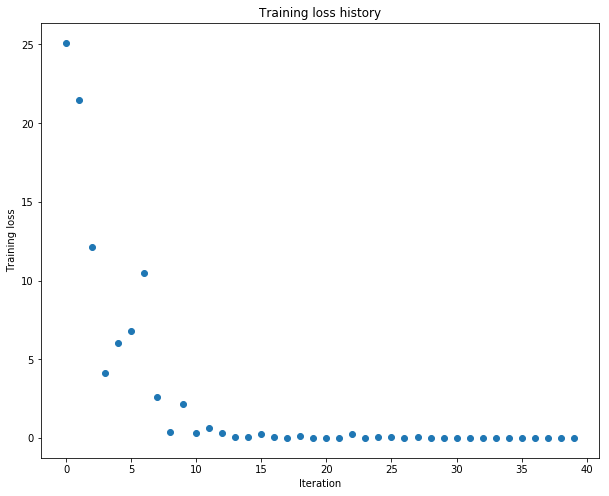

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples.
import random
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

max_count = 1 #before=30
# find the best learning rate and weight scale by changing the uniform :)
for count in xrange(max_count):
    #learning_rate = 10**random.uniform(-4,0)
    #weight_scale = 10**random.uniform(-4,0)
    # best values found for 100% accuracy on training set
    learning_rate=0.000894251014039
    weight_scale=0.0736354068714
    model = FullyConnectedNet([100, 100, 100, 100],
                    weight_scale=weight_scale, dtype=np.float64)
    solver = Solver(model, small_data,
                    num_epochs=20, batch_size=25,
                    update_rule='sgd', verbose=True,
                    optim_config={
                      'learning_rate': learning_rate,
                    }
             )
    #solver = Solver(model, small_data,
    #               print_every=10, num_epochs=20, batch_size=25,
    #                update_rule='sgd',
    #                optim_config={
    #                  'learning_rate': learning_rate,
    #                }
    #         )
    solver.train()
    #print "lr=" + str(learning_rate) + ",ws=" + str(weight_scale) \
    #      + "loss=" + str(solver.loss_history[-1])
    plt.plot(solver.loss_history, 'o')
    plt.title('Training loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Training loss')
    plt.show()


# Inline question: 
##Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
##It took the five layer net more epochs to overfit the small data. This is ofcourse becouse the net is much bigger and we need to adjsut more parameters


# Update rules
##So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
##Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

##Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [15]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print 'next_w error: ', rel_error(next_w, expected_next_w)
print 'velocity error: ', rel_error(expected_velocity, config['velocity'])

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


##Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print 'running with ', update_rule
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)


for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(12, 9)
plt.show()

#plt.show()


running with  sgd
(Iteration 1 / 200) loss: 2.619604
(Epoch 0 / 5) train acc: 0.123000; val_acc: 0.113000


(Iteration 11 / 200) loss: 2.237211


(Iteration 21 / 200) loss: 2.070006


(Iteration 31 / 200) loss: 2.087299


(Epoch 1 / 5) train acc: 0.271000; val_acc: 0.255000
(Iteration 41 / 200) loss: 1.951297


(Iteration 51 / 200) loss: 2.050037


(Iteration 61 / 200) loss: 1.979386


(Iteration 71 / 200) loss: 1.839300


(Epoch 2 / 5) train acc: 0.339000; val_acc: 0.309000
(Iteration 81 / 200) loss: 1.819204


(Iteration 91 / 200) loss: 1.811406
(Iteration 101 / 200) loss: 1.610771


(Iteration 111 / 200) loss: 1.877843


(Epoch 3 / 5) train acc: 0.381000; val_acc: 0.340000
(Iteration 121 / 200) loss: 1.674205


(Iteration 131 / 200) loss: 1.723115
(Iteration 141 / 200) loss: 1.661834


(Iteration 151 / 200) loss: 1.820741


(Epoch 4 / 5) train acc: 0.387000; val_acc: 0.314000
(Iteration 161 / 200) loss: 1.687216


(Iteration 171 / 200) loss: 1.462312


(Iteration 181 / 200) loss: 1.690281
(Iteration 191 / 200) loss: 1.754754


(Epoch 5 / 5) train acc: 0.411000; val_acc: 0.344000

running with  sgd_momentum
(Iteration 1 / 200) loss: 2.746056
(Epoch 0 / 5) train acc: 0.107000; val_acc: 0.095000


(Iteration 11 / 200) loss: 2.204067
(Iteration 21 / 200) loss: 1.997009


(Iteration 31 / 200) loss: 1.855784


(Epoch 1 / 5) train acc: 0.290000; val_acc: 0.287000
(Iteration 41 / 200) loss: 1.917104


(Iteration 51 / 200) loss: 1.823975


(Iteration 61 / 200) loss: 1.769328


(Iteration 71 / 200) loss: 1.601429


(Epoch 2 / 5) train acc: 0.407000; val_acc: 0.339000
(Iteration 81 / 200) loss: 1.854168


(Iteration 91 / 200) loss: 1.514629
(Iteration 101 / 200) loss: 1.653702


(Iteration 111 / 200) loss: 1.526549


(Epoch 3 / 5) train acc: 0.427000; val_acc: 0.321000
(Iteration 121 / 200) loss: 1.991298


(Iteration 131 / 200) loss: 1.545878
(Iteration 141 / 200) loss: 1.529943


(Iteration 151 / 200) loss: 1.739621


(Epoch 4 / 5) train acc: 0.482000; val_acc: 0.349000
(Iteration 161 / 200) loss: 1.423061


(Iteration 171 / 200) loss: 1.663256


(Iteration 181 / 200) loss: 1.378620
(Iteration 191 / 200) loss: 1.543203


(Epoch 5 / 5) train acc: 0.531000; val_acc: 0.366000



# RMSProp and Adam
##RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

##In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

##[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

##[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [17]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print 'next_w error: ', rel_error(expected_next_w, next_w)
print 'cache error: ', rel_error(expected_cache, config['cache'])

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


In [18]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print 'next_w error: ', rel_error(expected_next_w, next_w)
print 'v error: ', rel_error(expected_v, config['v'])
print 'm error: ', rel_error(expected_m, config['m'])

next_w error:  0.00152184517579
v error:  4.20831403811e-09
m error:  4.21496319311e-09


##Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

In [19]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print 'running with ', update_rule
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)

#plt.gcf().set_size_inches(15,15)
plt.show(block=True)
#fig.savefig('vs.png')

running with  adam
(Iteration 1 / 200) loss: 2.553336


(Epoch 0 / 5) train acc: 0.100000; val_acc: 0.081000


(Iteration 11 / 200) loss: 2.282336


(Iteration 21 / 200) loss: 2.140987


(Iteration 31 / 200) loss: 2.153071


(Epoch 1 / 5) train acc: 0.266000; val_acc: 0.227000
(Iteration 41 / 200) loss: 2.129139


(Iteration 51 / 200) loss: 1.896674


(Iteration 61 / 200) loss: 1.919642


(Iteration 71 / 200) loss: 1.845462


(Epoch 2 / 5) train acc: 0.346000; val_acc: 0.303000
(Iteration 81 / 200) loss: 1.819396


(Iteration 91 / 200) loss: 1.972448


(Iteration 101 / 200) loss: 1.673785


(Iteration 111 / 200) loss: 1.886822


(Epoch 3 / 5) train acc: 0.411000; val_acc: 0.334000
(Iteration 121 / 200) loss: 1.937087


(Iteration 131 / 200) loss: 1.649585


(Iteration 141 / 200) loss: 1.587846


(Iteration 151 / 200) loss: 1.627698


(Epoch 4 / 5) train acc: 0.445000; val_acc: 0.338000
(Iteration 161 / 200) loss: 1.466962


(Iteration 171 / 200) loss: 1.689651


(Iteration 181 / 200) loss: 1.643345


(Iteration 191 / 200) loss: 1.512969


(Epoch 5 / 5) train acc: 0.444000; val_acc: 0.345000

running with  rmsprop
(Iteration 1 / 200) loss: 2.705282
(Epoch 0 / 5) train acc: 0.128000; val_acc: 0.121000


(Iteration 11 / 200) loss: 2.061656


(Iteration 21 / 200) loss: 1.966947


(Iteration 31 / 200) loss: 1.873085


(Epoch 1 / 5) train acc: 0.339000; val_acc: 0.269000
(Iteration 41 / 200) loss: 1.930291


(Iteration 51 / 200) loss: 1.605560


(Iteration 61 / 200) loss: 1.667498


(Iteration 71 / 200) loss: 1.752410


(Epoch 2 / 5) train acc: 0.414000; val_acc: 0.320000
(Iteration 81 / 200) loss: 1.483188


(Iteration 91 / 200) loss: 1.667931


(Iteration 101 / 200) loss: 1.514169


(Iteration 111 / 200) loss: 1.613233


(Epoch 3 / 5) train acc: 0.454000; val_acc: 0.347000
(Iteration 121 / 200) loss: 1.511615


(Iteration 131 / 200) loss: 1.511568


(Iteration 141 / 200) loss: 1.540754


(Iteration 151 / 200) loss: 1.554306


(Epoch 4 / 5) train acc: 0.504000; val_acc: 0.363000
(Iteration 161 / 200) loss: 1.465884


(Iteration 171 / 200) loss: 1.424887


(Iteration 181 / 200) loss: 1.480269


(Iteration 191 / 200) loss: 1.337194


(Epoch 5 / 5) train acc: 0.526000; val_acc: 0.353000



# Train a good model!
##Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

##If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

##You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [7]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
max_count = 1 #before=30
# find the best learning rate and weight scale by changing the uniform :)
for count in xrange(max_count):
    #lr = 10**random.uniform(-5,0)
    #ws = 10**random.uniform(-5,0)
    #print "lr=" + str(lr) + ",ws=" + str(ws)
    lr=1e-4
    ws=5e-2
    best_model = FullyConnectedNet([100, 100, 100, 100], weight_scale=ws,use_batchnorm=True)
    solver = Solver(best_model, data,
                  num_epochs=20, batch_size=500,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': lr,
                  },
                  verbose=True)
    solver.train()
    
    y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
    y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
    print 'Val_acc: ', (y_val_pred == data['y_val']).mean()
    print 'Test_acc: ', (y_test_pred == data['y_test']).mean()
    print '------------'
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 1960) loss: 2.359859
(Epoch 0 / 20) train acc: 0.123000; val_acc: 0.127000


(Iteration 11 / 1960) loss: 2.062342


(Iteration 21 / 1960) loss: 1.870817


(Iteration 31 / 1960) loss: 1.864905


(Iteration 41 / 1960) loss: 1.704688


(Iteration 51 / 1960) loss: 1.724256


(Iteration 61 / 1960) loss: 1.640787


(Iteration 71 / 1960) loss: 1.655577


(Iteration 81 / 1960) loss: 1.591855


(Iteration 91 / 1960) loss: 1.604811


(Epoch 1 / 20) train acc: 0.451000; val_acc: 0.451000


(Iteration 101 / 1960) loss: 1.589471


(Iteration 111 / 1960) loss: 1.565396


(Iteration 121 / 1960) loss: 1.539135


(Iteration 131 / 1960) loss: 1.526108


(Iteration 141 / 1960) loss: 1.473433


(Iteration 151 / 1960) loss: 1.528384


(Iteration 161 / 1960) loss: 1.504305


(Iteration 171 / 1960) loss: 1.426749


(Iteration 181 / 1960) loss: 1.425677


(Iteration 191 / 1960) loss: 1.504105


(Epoch 2 / 20) train acc: 0.488000; val_acc: 0.471000


(Iteration 201 / 1960) loss: 1.440993


(Iteration 211 / 1960) loss: 1.484435


(Iteration 221 / 1960) loss: 1.449220


(Iteration 231 / 1960) loss: 1.451805


(Iteration 241 / 1960) loss: 1.444024


(Iteration 251 / 1960) loss: 1.472073


(Iteration 261 / 1960) loss: 1.327339


(Iteration 271 / 1960) loss: 1.342613


(Iteration 281 / 1960) loss: 1.332414


(Iteration 291 / 1960) loss: 1.383879


(Epoch 3 / 20) train acc: 0.503000; val_acc: 0.495000


(Iteration 301 / 1960) loss: 1.380525


(Iteration 311 / 1960) loss: 1.356574


(Iteration 321 / 1960) loss: 1.406504


(Iteration 331 / 1960) loss: 1.392462


(Iteration 341 / 1960) loss: 1.307607


(Iteration 351 / 1960) loss: 1.420829


(Iteration 361 / 1960) loss: 1.321703


(Iteration 371 / 1960) loss: 1.344153


(Iteration 381 / 1960) loss: 1.337377


(Iteration 391 / 1960) loss: 1.344850
(Epoch 4 / 20) train acc: 0.537000; val_acc: 0.501000


(Iteration 401 / 1960) loss: 1.295596


(Iteration 411 / 1960) loss: 1.283999


(Iteration 421 / 1960) loss: 1.216578


(Iteration 431 / 1960) loss: 1.356040


(Iteration 441 / 1960) loss: 1.270096


(Iteration 451 / 1960) loss: 1.375999


(Iteration 461 / 1960) loss: 1.243436


(Iteration 471 / 1960) loss: 1.265088


(Iteration 481 / 1960) loss: 1.300965


(Epoch 5 / 20) train acc: 0.499000; val_acc: 0.505000
(Iteration 491 / 1960) loss: 1.316842


(Iteration 501 / 1960) loss: 1.227216


(Iteration 511 / 1960) loss: 1.372579


(Iteration 521 / 1960) loss: 1.241584


(Iteration 531 / 1960) loss: 1.268372


(Iteration 541 / 1960) loss: 1.217404


(Iteration 551 / 1960) loss: 1.248639


(Iteration 561 / 1960) loss: 1.264800


(Iteration 571 / 1960) loss: 1.310504


(Iteration 581 / 1960) loss: 1.338002


(Epoch 6 / 20) train acc: 0.551000; val_acc: 0.506000


(Iteration 591 / 1960) loss: 1.231527


(Iteration 601 / 1960) loss: 1.323325


(Iteration 611 / 1960) loss: 1.260482


(Iteration 621 / 1960) loss: 1.223648


(Iteration 631 / 1960) loss: 1.203437


(Iteration 641 / 1960) loss: 1.153892


(Iteration 651 / 1960) loss: 1.187290


(Iteration 661 / 1960) loss: 1.218338


(Iteration 671 / 1960) loss: 1.258845


(Iteration 681 / 1960) loss: 1.208459


(Epoch 7 / 20) train acc: 0.562000; val_acc: 0.517000


(Iteration 691 / 1960) loss: 1.265572


(Iteration 701 / 1960) loss: 1.171776


(Iteration 711 / 1960) loss: 1.242681


(Iteration 721 / 1960) loss: 1.157227


(Iteration 731 / 1960) loss: 1.226453


(Iteration 741 / 1960) loss: 1.237816


(Iteration 751 / 1960) loss: 1.166667


(Iteration 761 / 1960) loss: 1.232520


(Iteration 771 / 1960) loss: 1.273167


(Iteration 781 / 1960) loss: 1.164273


(Epoch 8 / 20) train acc: 0.552000; val_acc: 0.523000


(Iteration 791 / 1960) loss: 1.128476


(Iteration 801 / 1960) loss: 1.135537


(Iteration 811 / 1960) loss: 1.240972


(Iteration 821 / 1960) loss: 1.192664


(Iteration 831 / 1960) loss: 1.141082


(Iteration 841 / 1960) loss: 1.261791


(Iteration 851 / 1960) loss: 1.169086


(Iteration 861 / 1960) loss: 1.148398


(Iteration 871 / 1960) loss: 1.058509


(Iteration 881 / 1960) loss: 1.082009
(Epoch 9 / 20) train acc: 0.586000; val_acc: 0.508000


(Iteration 891 / 1960) loss: 1.171426


(Iteration 901 / 1960) loss: 1.115615


(Iteration 911 / 1960) loss: 1.181248


(Iteration 921 / 1960) loss: 1.078135


(Iteration 931 / 1960) loss: 1.134396


(Iteration 941 / 1960) loss: 1.099138


(Iteration 951 / 1960) loss: 1.091474


(Iteration 961 / 1960) loss: 1.088939


(Iteration 971 / 1960) loss: 1.098115


(Epoch 10 / 20) train acc: 0.612000; val_acc: 0.516000
(Iteration 981 / 1960) loss: 1.165630


(Iteration 991 / 1960) loss: 1.123219


(Iteration 1001 / 1960) loss: 1.156377


(Iteration 1011 / 1960) loss: 1.102453


(Iteration 1021 / 1960) loss: 1.071357


(Iteration 1031 / 1960) loss: 1.113374


(Iteration 1041 / 1960) loss: 1.074847


(Iteration 1051 / 1960) loss: 1.133556


(Iteration 1061 / 1960) loss: 1.039766


(Iteration 1071 / 1960) loss: 1.140030


(Epoch 11 / 20) train acc: 0.593000; val_acc: 0.516000


(Iteration 1081 / 1960) loss: 1.171870


(Iteration 1091 / 1960) loss: 1.169119


(Iteration 1101 / 1960) loss: 1.080559


(Iteration 1111 / 1960) loss: 1.116753


(Iteration 1121 / 1960) loss: 1.182492


(Iteration 1131 / 1960) loss: 1.058975


(Iteration 1141 / 1960) loss: 1.041199


(Iteration 1151 / 1960) loss: 1.134758


(Iteration 1161 / 1960) loss: 1.020757


(Iteration 1171 / 1960) loss: 1.097406


(Epoch 12 / 20) train acc: 0.609000; val_acc: 0.514000


(Iteration 1181 / 1960) loss: 1.104123


(Iteration 1191 / 1960) loss: 1.096878


(Iteration 1201 / 1960) loss: 1.108285


(Iteration 1211 / 1960) loss: 1.052985


(Iteration 1221 / 1960) loss: 1.066445


(Iteration 1231 / 1960) loss: 1.090085


(Iteration 1241 / 1960) loss: 1.093648


(Iteration 1251 / 1960) loss: 1.147220


(Iteration 1261 / 1960) loss: 1.187808


(Iteration 1271 / 1960) loss: 0.965445


(Epoch 13 / 20) train acc: 0.614000; val_acc: 0.514000


(Iteration 1281 / 1960) loss: 1.075159


(Iteration 1291 / 1960) loss: 1.039658


(Iteration 1301 / 1960) loss: 1.058309


(Iteration 1311 / 1960) loss: 1.020465


(Iteration 1321 / 1960) loss: 0.982006


(Iteration 1331 / 1960) loss: 0.983581


(Iteration 1341 / 1960) loss: 1.050763


(Iteration 1351 / 1960) loss: 1.171548


(Iteration 1361 / 1960) loss: 1.022733


(Iteration 1371 / 1960) loss: 1.035347
(Epoch 14 / 20) train acc: 0.618000; val_acc: 0.518000


(Iteration 1381 / 1960) loss: 1.060856


(Iteration 1391 / 1960) loss: 0.990757


(Iteration 1401 / 1960) loss: 1.048411


(Iteration 1411 / 1960) loss: 1.026555


(Iteration 1421 / 1960) loss: 1.040583


(Iteration 1431 / 1960) loss: 1.034527


(Iteration 1441 / 1960) loss: 1.072294


(Iteration 1451 / 1960) loss: 1.136523


(Iteration 1461 / 1960) loss: 0.958773


(Epoch 15 / 20) train acc: 0.601000; val_acc: 0.516000
(Iteration 1471 / 1960) loss: 0.969585


(Iteration 1481 / 1960) loss: 1.040907


(Iteration 1491 / 1960) loss: 1.043175


(Iteration 1501 / 1960) loss: 0.996407


(Iteration 1511 / 1960) loss: 1.028325


(Iteration 1521 / 1960) loss: 1.043575


(Iteration 1531 / 1960) loss: 1.012074


(Iteration 1541 / 1960) loss: 1.020024


(Iteration 1551 / 1960) loss: 0.981284


(Iteration 1561 / 1960) loss: 0.999405


(Epoch 16 / 20) train acc: 0.657000; val_acc: 0.527000


(Iteration 1571 / 1960) loss: 1.073274


(Iteration 1581 / 1960) loss: 1.034570


(Iteration 1591 / 1960) loss: 1.004619


(Iteration 1601 / 1960) loss: 0.963683


(Iteration 1611 / 1960) loss: 1.072580


(Iteration 1621 / 1960) loss: 0.957940


(Iteration 1631 / 1960) loss: 1.012020


(Iteration 1641 / 1960) loss: 0.935672


(Iteration 1651 / 1960) loss: 1.063510


(Iteration 1661 / 1960) loss: 0.896816


(Epoch 17 / 20) train acc: 0.638000; val_acc: 0.509000


(Iteration 1671 / 1960) loss: 1.038905


(Iteration 1681 / 1960) loss: 1.039609


(Iteration 1691 / 1960) loss: 0.973145


(Iteration 1701 / 1960) loss: 1.011531


(Iteration 1711 / 1960) loss: 1.015130


(Iteration 1721 / 1960) loss: 1.025756


(Iteration 1731 / 1960) loss: 0.946741


(Iteration 1741 / 1960) loss: 1.049664


(Iteration 1751 / 1960) loss: 1.020597


(Iteration 1761 / 1960) loss: 0.995000


(Epoch 18 / 20) train acc: 0.639000; val_acc: 0.510000


(Iteration 1771 / 1960) loss: 0.995721


(Iteration 1781 / 1960) loss: 1.050865


(Iteration 1791 / 1960) loss: 0.918869


(Iteration 1801 / 1960) loss: 0.942125


(Iteration 1811 / 1960) loss: 0.952146


(Iteration 1821 / 1960) loss: 0.941858


(Iteration 1831 / 1960) loss: 1.036260


(Iteration 1841 / 1960) loss: 0.870321


(Iteration 1851 / 1960) loss: 1.016369


(Iteration 1861 / 1960) loss: 0.917795
(Epoch 19 / 20) train acc: 0.620000; val_acc: 0.513000


(Iteration 1871 / 1960) loss: 0.831112


(Iteration 1881 / 1960) loss: 0.962037


(Iteration 1891 / 1960) loss: 0.946166


(Iteration 1901 / 1960) loss: 0.951887


(Iteration 1911 / 1960) loss: 0.867213


(Iteration 1921 / 1960) loss: 0.939301


(Iteration 1931 / 1960) loss: 1.017307


(Iteration 1941 / 1960) loss: 0.986169


(Iteration 1951 / 1960) loss: 0.938321


(Epoch 20 / 20) train acc: 0.623000; val_acc: 0.509000
Val_acc:  0.549
Test_acc:  0.515
------------


# Test you model
##Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [8]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

Validation set accuracy:  0.549
Test set accuracy:  0.515
